# Import libraries, create document class to hold info

In [1]:
#  /Data/celebs-usa/female contains 381 texts by females
#  /Data/celebs-usa/male contains 912 texts by males
#  /Data/celebs-other-json contains text by

# Identify birth year as that is a constant, these tweets are from 2011-2018, age range constantly changes but birth year stays constant
# using birth year, predict age 10-15, 15-20, 20-25, 25-30, 30-35, 35-40, 45-55,55+  
#{'25-34', '35-44', '45-54', '55-64', '65+'}

from os import listdir, makedirs
from os.path import isfile, join, splitext, split
import json
from collections import Counter
import ftfy
import re
import nltk
import copy
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import ndjson
import pickle
import os
import jsonlines
from sklearn.base import BaseEstimator, TransformerMixin

        
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

        
class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        
    def extract_features_from_text(self, text):
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens) #updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens
    
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)
            
def get_tokens_fql(document):
    return document.tokens_fql

def get_pos_fql(document):
    return document.pos_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }


def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) 
    #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

def custom_tokenise(text):
    return tokenise_re.findall(text.lower())

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (5, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

# Reading in Celebrity Data, converting to Document Class and saving to pickle file

In [2]:
'''
This gets the celebrity data and adds the correct gender and ages 
to each json object with text
'''
def getCelebData():
    path = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/feeds.ndjson'
    path2 = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/labels.ndjson'
    x=0
    # Read in the twitter text
    data = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            x+=1
            print('Reading no ',x)
            data.append(obj)
            if len(data) >29999:
                break;
    # Here the correct labels are identified and paried           
    labels = []
    with jsonlines.open(path2) as reader:
        for obj in reader:
            if obj['gender']!='nonbinary':
                for d in data:
                    if d['id'] == obj['id']:
                        d['gender'] = obj['gender']
                        d['birthyear'] = obj['birthyear']
    return data

'''
This function returns the 5 year group a year of birth resides in, e.g. 1995 is between 1995-1999 (inclusive 5 year period)
'''
def getYearRange(yearOfBirth):
    YearGroupGap = 5
    for minYear in range(1900,2015,YearGroupGap):
        maxYear = minYear+YearGroupGap
        #print('min: ',minYear,'max: ',maxYear)
        if (yearOfBirth >= minYear) and (yearOfBirth < maxYear):
            return( str(minYear)+'-'+str(maxYear-1) )
    raise Exception('year of Birth passed in - ' + str(yearOfBirth)+' is not in range of min and max years' ) 
    

'''
This helper function uses the Document class to return a doc
class for each user with the correct gender, age and tweets
'''
def getDocument(data):
    try:
        gender    = data['gender']
        birthyear = data['birthyear']
        if data['birthyear'] != 'unknown':
            birthYearRange = getYearRange(data['birthyear'])

        doc = Document({'gender': gender, 'birthyear':birthyear, 'birthyearrange':birthYearRange}) #include metadata
        for tweet in data['text']:
            doc.extract_features_from_text(tweet)
        return doc
    except:
        print("An exception occurred")

'''
Check if the pickle file exists, if not then create it, else read in
'''
corpus = []
if os.path.exists("/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile"):
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'rb') as fp:
        corpus = pickle.load(fp)
    print('CELEB FILE EXISTS')
else:
    print('CELEB FILE DOES NOT EXISTS, CREATING')
    # Call the function to get the twitter data
    corpus = getCelebData()
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/UnProcessedCelebFile', 'wb') as fpc:
        pickle.dump(corpus, fpc)
    #For each json object, convert it to a document object
    for i in range(len(corpus)):
        print('Doing Obj Number: ',i)
        corpus[i] = getDocument(corpus[i])
    
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'wb') as fp:
        pickle.dump(corpus, fp)
    print('CELEB FILE CREATED')

CELEB FILE EXISTS


# Exploratory Data Analysis

/home/jay/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


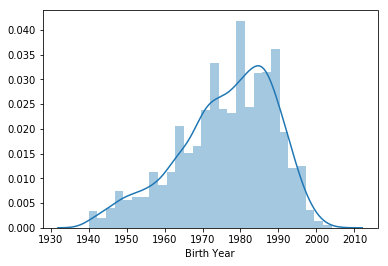

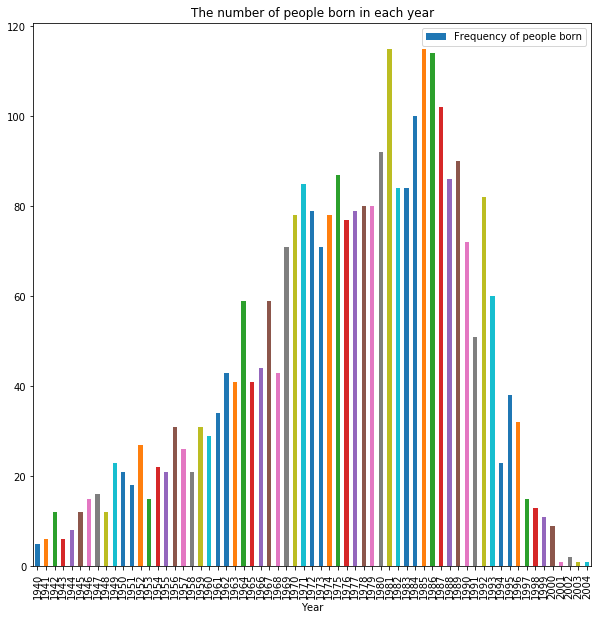

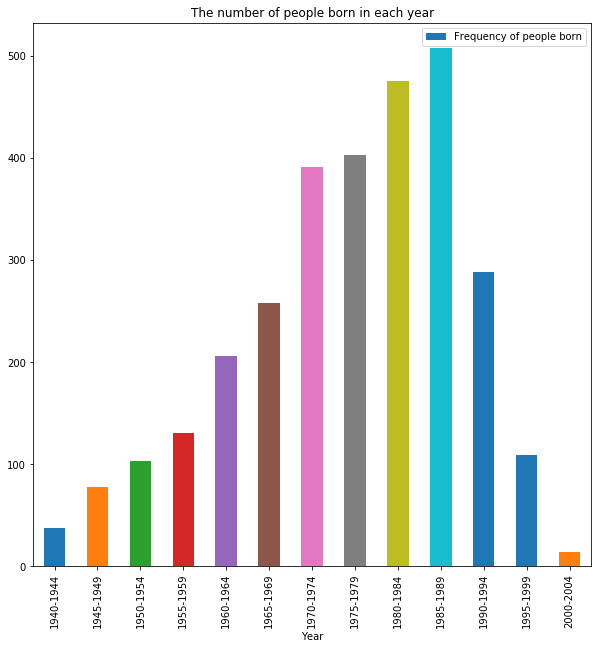

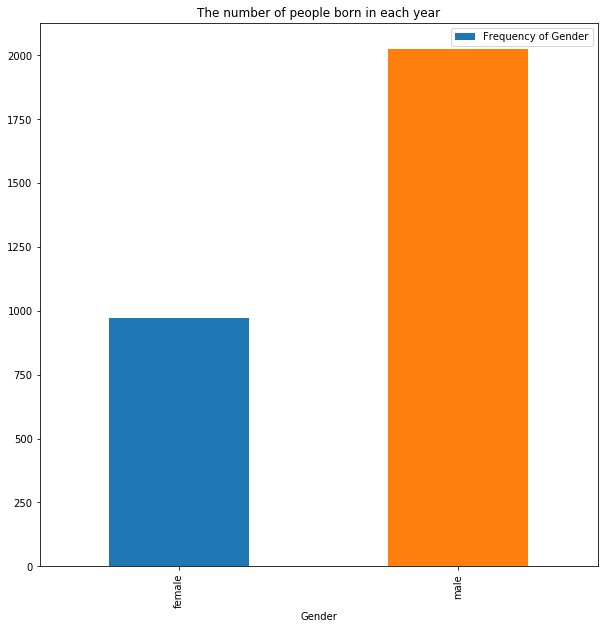

In [3]:
corpus = [d for d in corpus if d.meta['gender'] != 'nonbinary']
#Get all the birth years and plot a histogram
birth_year_y = [d.meta['birthyear'] for d in corpus]
x = pd.Series(birth_year_y, name="Birth Year")
sns.distplot(x)

#Get a count of of the birth years and plot a bar chart
df = pd.DataFrame.from_dict(Counter(birth_year_y), orient='index').reset_index()
df.columns = ['Year','Frequency of people born']
df = df.sort_values(by=['Year'])
df.plot.bar(x='Year', y='Frequency of people born', rot=90,figsize=(10,10), title='The number of people born in each year')
BirthYearDF = copy.deepcopy(df)

#Get all the birth years and plot a histogram
birth_year_y = [d.meta['birthyearrange'] for d in corpus]
df = pd.DataFrame.from_dict(Counter(birth_year_y), orient='index').reset_index()
df.columns = ['Year','Frequency of people born']
df = df.sort_values(by=['Year'])
df.plot.bar(x='Year', y='Frequency of people born', rot=90,figsize=(10,10), title='The number of people born in each year')


#Get all the genders and plot a bar chart
gender_y = [d.meta['gender'] for d in corpus]
df = pd.DataFrame.from_dict(Counter(gender_y), orient='index').reset_index()
df.columns = ['Gender','Frequency of Gender']
df.plot.bar(x='Gender', y='Frequency of Gender', rot=90,figsize=(10,10), title='The number of people born in each year')



# Get Train and Test Split

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

##################THIS NEEDS TO BE DEALT WITh
#Undersample men 
femaleCorpus = [d for d in corpus if d.meta['gender'] == 'female']
maleCorpus   = [d for d in corpus if d.meta['gender'] == 'male']
genderCorpus = maleCorpus[:1000] + femaleCorpus
##################THIS NEEDS TO BE DEALT WITh
#Undersample men    

#Getting gender Train and Test
gender_y = [d.meta['gender'] for d in genderCorpus]
gender_X = genderCorpus
Gender_X_train, Gender_X_test, Gender_y_train, Gender_y_test = train_test_split(gender_X,gender_y, test_size=0.3, random_state = 0)
genderCorpus = [d for d in corpus if d.meta['gender'] != 'nonbinary']

#Getting Birth_year_range Train and Test
birth_year_y = [d.meta['birthyearrange'] for d in corpus]
birth_year_y = [d.meta['birthyear'] for d in corpus]
birth_year_X = corpus
Birth_X_train, Birth_X_test, Birth_y_train, Birth_y_test = train_test_split(birth_year_X,birth_year_y, test_size=0.3, random_state = 0)
genderCorpus = [d for d in corpus if d.meta['gender'] != 'nonbinary']


GenderCount = Counter(gender_y)
BirthYearCount = Counter(birth_year_y)
print(GenderCount)
print('---------------')
print(BirthYearCount)

Counter({'male': 1000, 'female': 973})
---------------
Counter({1985: 115, 1981: 115, 1986: 114, 1987: 102, 1984: 100, 1980: 92, 1989: 90, 1975: 87, 1988: 86, 1971: 85, 1982: 84, 1983: 84, 1992: 82, 1978: 80, 1979: 80, 1977: 79, 1972: 79, 1974: 78, 1970: 78, 1976: 77, 1990: 72, 1969: 71, 1973: 71, 1993: 60, 1967: 59, 1964: 59, 1991: 51, 1966: 44, 1968: 43, 1962: 43, 1965: 41, 1963: 41, 1995: 38, 1961: 34, 1996: 32, 1959: 31, 1956: 31, 1960: 29, 1952: 27, 1957: 26, 1994: 23, 1949: 23, 1954: 22, 1955: 21, 1958: 21, 1950: 21, 1951: 18, 1947: 16, 1997: 15, 1946: 15, 1953: 15, 1998: 13, 1942: 12, 1945: 12, 1948: 12, 1999: 11, 2000: 9, 1944: 8, 1941: 6, 1943: 6, 1940: 5, 2002: 2, 2004: 1, 2001: 1, 2003: 1})


# Model Selection, GridSearch to identify best classifier and best params

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline #,FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold
#from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, VotingClassifier, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
#from sklean.metrics import metrics
import math
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.svm import SVC
#from sklearn.feature_extraction import FeatureHasher


'''
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pos_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('clf', None), # to be set by grid search.
])

param_grid={ 'clf': [LogisticRegression(solver='liblinear', random_state=0)
                     ,MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
                     RandomForestClassifier(),
                    MLPClassifier(max_iter=400)
                    ],
    
            'union__word__processor__process_method': [get_tokens_fql, get_fws_fql, get_pos_fql, get_text_stats],}


search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )



print('Fitting Clf')
search.fit(Gender_X_train, Gender_y_train)
print('Getting Predictions')
predictions = search.predict(Gender_X_test)

print("Accuracy: ", accuracy_score(Gender_y_test, predictions))
print(classification_report(Gender_y_test, predictions))
print(confusion_matrix(Gender_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(Gender_y_test,predictions), ['M','F'])
'''

'\nmodel = Pipeline([\n    (\'union\', FeatureUnion(\n        transformer_list = [\n            (\'word\', Pipeline([\n                (\'processor\', DocumentProcessor(process_method = get_pos_fql)),\n                (\'vectorizer\', DictVectorizer()),\n            ])),\n        ],\n    )),\n    (\'clf\', None), # to be set by grid search.\n])\n\nparam_grid={ \'clf\': [LogisticRegression(solver=\'liblinear\', random_state=0)\n                     ,MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),\n                     RandomForestClassifier(),\n                    MLPClassifier(max_iter=400)\n                    ],\n    \n            \'union__word__processor__process_method\': [get_tokens_fql, get_fws_fql, get_pos_fql, get_text_stats],}\n\n\nsearch = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, random_state=0), \n                      return_train_score = False, \n                      scoring = [\'accuracy\', \'precision_weighted\', \'recall_weighted\', \'f1_weighte

# Predicting Birth Year

In [6]:
clf = DecisionTreeRegressor()
regr = linear_model.LinearRegression()
reg = linear_model.BayesianRidge()

no_estimators= 100

#Ada boost SVR with pos_fql
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
AdaBoostSVR = BaggingRegressor(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostSVR_get_pos_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_pos_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostSVR),
])

#Ada boost Random Forest with pos_fql
clf = RandomForestRegressor(n_estimators=100)
AdaBoostRandomForest = BaggingRegressor(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostRandomForest_get_pos_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_pos_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostRandomForest),
])

#Ada boost Bayesian Ridge with pos_fql
clf = linear_model.BayesianRidge()
AdaBoostBayesianRidge = BaggingRegressor(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostBayesianRidge_get_pos_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_pos_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostRandomForest),
])

#Ada boost SVR with fws_fql
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
AdaBoostSVR = BaggingRegressor(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostSVR_get_fws_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_pos_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostSVR),
])


'''
Creating Master Pipeline to fit each ensemble and average the result
'''
PipeLineList = [Pipeline_AdaBoostRandomForest_get_pos_fql, 
                Pipeline_AdaBoostSVR_get_pos_fql,
                Pipeline_AdaBoostSVR_get_fws_fql,
                Pipeline_AdaBoostBayesianRidge_get_pos_fql]

predictions= [0] * 900
x = 0
print('Fitting clfs')
for pipeline in PipeLineList:
    x+=1
    print('Fitting Clf number ',x)
    pipeline.fit(Birth_X_train, Birth_y_train)
    print('Getting Predictions ', x)
    predictions += pipeline.predict(Birth_X_test)

predictions = predictions / len(PipeLineList)

    
'''
print('Fitting Clf')
BirthYearPipeline.fit(Birth_X_train, Birth_y_train)
print('Saving Model')
filename = 'BirthYearRegression_AdaBoost50.sav'
pickle.dump(BirthYearPipeline, open(filename, 'wb'))
BirthYearPipeline = pickle.load(open(filename, 'rb'))
print('Getting Predictions')
predictions = BirthYearPipeline.predict(Birth_X_test)
predictions = [round(x) for x in predictions]'''

Fitting clfs
Fitting Clf number  1
Getting Predictions  1
Fitting Clf number  2
Getting Predictions  2
Fitting Clf number  3
Getting Predictions  3
Fitting Clf number  4
Getting Predictions  4


"\nprint('Fitting Clf')\nBirthYearPipeline.fit(Birth_X_train, Birth_y_train)\nprint('Saving Model')\nfilename = 'BirthYearRegression_AdaBoost50.sav'\npickle.dump(BirthYearPipeline, open(filename, 'wb'))\nBirthYearPipeline = pickle.load(open(filename, 'rb'))\nprint('Getting Predictions')\npredictions = BirthYearPipeline.predict(Birth_X_test)\npredictions = [round(x) for x in predictions]"

# Evaluating Birth Year Classifier

RMSE:  10.3163028445978
MSLE:  2.7346341333536484e-05
R2 Score:  -1.9196096605498512
MAE:  8.112083677736008


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

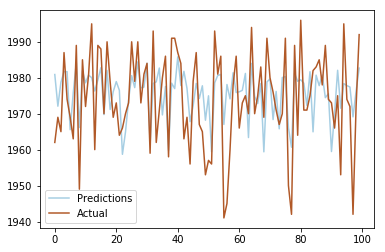

In [7]:
print('RMSE: ', math.sqrt(mean_squared_error(predictions,Birth_y_test)))
print('MSLE: ', mean_squared_log_error(predictions,Birth_y_test))
print('R2 Score: ', r2_score(predictions,Birth_y_test))
print('MAE: ', mean_absolute_error(predictions,Birth_y_test))


res = pd.DataFrame( data = {'Predictions': predictions, 'Actual': Birth_y_test} )
res[:100].plot( colormap='Paired')

print("Accuracy: ", accuracy_score(Birth_y_test, predictions))
print(classification_report(Birth_y_test, predictions))
print(confusion_matrix(Birth_y_test, predictions))


#labels = list(set(Birth_y_test+predictions))

confusion_matrix_heatmap(confusion_matrix(Birth_y_test,predictions)  )





# Predicting Gender

In [ ]:


no_estimators= 1

#Ada boost SVM with pos_fql
#clf = SVC(gamma='auto', verbose=True, algorithm='SAMME')
#clf = SGDClassifier(loss='hinge', algorithm='SAMME')
clf = SVC(probability=True, kernel='linear', verbose=True)
AdaBoostSVM = clf #AdaBoostClassifier(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostSVM_get_pos_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_tokens_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostSVM),
])

#Ada boost Random Forest with pos_fql
clf = MLPClassifier(random_state=0, verbose=1, max_iter=50)
AdaBoostMLP = clf #AdaBoostClassifier(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostMLP_get_pos_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_tokens_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostMLP),
])

#Ada boost Random Forest with pos_fql
clf = MLPClassifier(random_state=0, verbose=1, max_iter=50)
AdaBoostMLP = clf #AdaBoostClassifier(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostMLP_get_FWS_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_fws_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostMLP),
])


#Ada boost Random Forest with pos_fql
clf = LogisticRegression(verbose=1)
AdaBoostMLP = clf #AdaBoostClassifier(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostLR_get_FWS_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_fws_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostMLP),
])


#Ada boost Bayesian Ridge with pos_fql
clf = LogisticRegression(verbose=1)
AdaBoostLogisticRegression = clf #AdaBoostClassifier(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostLR_get_pos_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_tokens_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostLogisticRegression),
])

#Ada boost SVR with fws_fql
clf = RandomForestClassifier(n_estimators=100, verbose=1)
AdaBoostRandForest = clf #AdaBoostClassifier(clf, n_estimators=no_estimators, random_state=0)
Pipeline_AdaBoostRandForest_get_fws_fql = Pipeline([
    ('processor', DocumentProcessor(process_method = get_tokens_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostRandForest),
])

'''
ListOfClassifiers = [('MLP', Pipeline_AdaBoostMLP_get_pos_fql),
                     ('SVM', Pipeline_AdaBoostSVM_get_pos_fql ), 
                     ('LR', Pipeline_AdaBoostLR_get_pos_fql), 
                     ('randfor', Pipeline_AdaBoostRandForest_get_fws_fql)], 
                      voting='hard')]

x=0
for clf in ListOfClassifiers:
    x+=1
    print('Fitting Clf: ', x)
    clf.fit(Gender_X_train, Gender_y_train)
    

    print('Getting Predictions')
    predictions = clf.predict(Gender_X_test)

'''
    
GenderPipeline = VotingClassifier(
    estimators=[('MLP', Pipeline_AdaBoostMLP_get_pos_fql),
                ('MLP2', Pipeline_AdaBoostMLP_get_FWS_fql),
                ('LR', Pipeline_AdaBoostLR_get_pos_fql),
                ('LR1', Pipeline_AdaBoostLR_get_pos_fql), 
                ('LR2', Pipeline_AdaBoostLR_get_pos_fql),
                ('LR3', Pipeline_AdaBoostLR_get_FWS_fql),
                ('randfor', Pipeline_AdaBoostRandForest_get_fws_fql)],
                voting='hard')



print('Fitting Clf')
GenderPipeline.fit(Gender_X_train, Gender_y_train)
print('Getting Predictions')
predictions = GenderPipeline.predict(Gender_X_test)
print('Got Predictions')

# Evaluating Gender Classifier

In [ ]:
print("Accuracy: ", accuracy_score(Gender_y_test, predictions))
print(classification_report(Gender_y_test, predictions))
print(confusion_matrix(Gender_y_test, predictions))

#confusion_matrix_heatmap(confusion_matrix(Gender_y_test, predictions), GenderPipeline.classes_)
confusion_matrix_heatmap(confusion_matrix(Gender_y_test, predictions), ['Male', 'Female'])


res = pd.DataFrame( data = {'Predictions': predictions, 'Actual': Gender_y_test} )

res = res.replace(['male', 'female'], [1, 0])

res[:20].plot( colormap='Paired')

math.sqrt(mean_squared_error(predictions,Gender_y_test))

# Stacked Generalisation Meta Classifier

In [ ]:
'''
# The stacked generalisation meta classifier (SGMC) is a combination of the gender ensemble and the birth year ensemble

#First the outputs of the of the predicted birth year from each of the bagging regressors need to be saved

#Then the output of predicted gender needs to be saved

#Along with the true birth year

So now a dataset with the following structure is created, where X are the features 
(outputs of the ensembles) and Y is the true birth year.

   X                         Y
1995,1994,1997,1999,1       1995
...................................
..................................
..................................
..................................
............


Once this has been done, the MLP Regressor can then be trained 
using the stacked generalisation method of hold one out
'''

StackedGeneralisationData = pd.DataFrame({"BirthYearPrediction1":[], 
                                        "BirthYearPrediction2":[],
                                        "BirthYearPrediction3":[],
                                        "BirthYearPrediction4":[],
                                        "GenderPrediction":[]
                                        "TrueValue":[]
                                       }) 


#First the outputs of the of the predicted birth year from each of the bagging regressors need to be saved
x = 0
for observation in trainingSet:
        x+=1
        print('Getting Predictions ', x)
        BirthYearPrediction1 += PipeLineList[0].predict(observation)
        BirthYearPrediction2 += PipeLineList[1].predict(observation)
        BirthYearPrediction3 += PipeLineList[2].predict(observation)
        BirthYearPrediction4 += PipeLineList[3].predict(observation)
        GenderPrediction = GenderPipeline.predict(observation)
        if GenderPrediction == 'Male':
            GenderPrediction = 1
        else:
            GenderPrediction = 0
        
        true_value = observation.true
        
        # Creating the first Dataframe using dictionary 
        StackedGeneralisation_Append = pd.DataFrame({"BirthYearPrediction1":[BirthYearPrediction1], 
                                                "BirthYearPrediction2":[BirthYearPrediction2],
                                                "BirthYearPrediction3":[BirthYearPrediction3],
                                                "BirthYearPrediction4":[BirthYearPrediction4],
                                                "GenderPrediction":[GenderPrediction]
                                                "TrueValue":[true_value]
                                               }) 
  
        StackedGeneralisationData.append(StackedGeneralisation_Append) 

#pickle save data    


# Evaluating Stacked Generalisation Meta Classifier

In [10]:
#Testing
path = 'alishapatel28_tweets.json'
#path = 'ashnapatel_tweets.json'
    
def getTestData():
    # Read in the twitter text
    data = []
    with open(path) as json_file:  
        data = json.load(json_file)

    return data

def getTestDocument(data):
    try:
        doc = Document({}) #include metadata
        for tweet in data:
            doc.extract_features_from_text(tweet['full_text'])
            #print(tweet['full_text'])
        return doc
    except:
        print("An exception occurred")
        
TestCorpus = getTestData()

TestCorpus = getTestDocument(TestCorpus)
PredictedBirthYear = 0
PredictedGender = ''
for pipeline in PipeLineList:
    PredictedYear = pipeline.predict([TestCorpus])
    print('Predicted Year: ',PredictedYear)
    PredictedBirthYear += PredictedYear
PredictedBirthYear = PredictedBirthYear/len(PipeLineList)

PredictedGender = GenderPipeline.predict([TestCorpus])     
print('Predicted Birth-Year for: ', path, 'is: ', PredictedBirthYear)
print('Predicted Age for ', path, 'is: ', 2018 - PredictedBirthYear )
print('Predicted Gender for: ', path, 'is: ', PredictedGender)



Predicted Year:  [1979.595]
Predicted Year:  [1981.69240383]
Predicted Year:  [1981.69240383]
Predicted Year:  [1979.595]


NameError: name 'GenderPipeline' is not defined

In [ ]:

'''
CODE TO UNDERSAMPLE BIRTH YEAR
'''
BirthYearDF = BirthYearDF.reset_index(drop=True)
averageFrequency = round(BirthYearDF['Frequency of people born'].mean())
BirthYearsThatNeedUnderSampling = BirthYearDF.loc[BirthYearDF['Frequency of people born'] > averageFrequency]
BirthYearsThatNeedUnderSampling = BirthYearsThatNeedUnderSampling.set_index('Year') #.T.to_dict('list')

BirthYearsThatNeedUnderSampling = BirthYearsThatNeedUnderSampling.to_dict()

BirthYearsThatNeedUnderSampling = BirthYearsThatNeedUnderSampling.get('Frequency of people born')

indexOfRowsToDelete = []
for index, row in df.iterrows():
    yearOfRow      = row['Year']
    FrequencyOfROw = row['Freqency']
    if yearOfRow in BirthYearsThatNeedUnderSampling:
        if FrequencyOfROw > averageFrequency:
            indexOfRowsToDelete.append(index)
            BirthYearsThatNeedUnderSampling[yearOfRow] -= 1
        
#delete all the birth years in that index

In [ ]:
for index, row in df.iterrows():
    print(row['Gender'], index)